In [1]:
%load_ext autoreload
%autoreload 2
%cd ".."
%matplotlib notebook

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

/media/flo/Data/Uni/NAIST/thesis/code/PoseCorrectorGNN


In [2]:
import torch
import os
from mpl_toolkits.mplot3d import Axes3D
import pprint
import matplotlib.pyplot as plt
import numpy as np

from data_utils import datasets
from evaluation.evaluator import Evaluator
from networks.gnn import PoseCorrectorGNNv1
from evaluation.analyzation import ExperimentAnalyzer, ModelAnalyzer
from data_utils import normalization
from data_utils.visualization import PoseVisualizer
from training.solver import Solver
from data_utils import distorters
from evaluation import errors
from data_utils import normalization as norm
from data_utils import helper as data_helper

In [3]:
# Load experiment results
experiment_name = 'hands17sc_mlp_nonorm_nodist_bredth_1'
analyzer = ExperimentAnalyzer(experiment_name)
analyzer.print_info()

/home/flo/anaconda3/envs/ma_thesis/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'networks.base_lines.AdditivePoseCorrectorMLP' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


{   'init_weights_path': None,
    'n_repetitions': 2,
    'name': 'hands17sc_mlp_nonorm_nodist_bredth_1',
    'normalizer': None,
    'target_device': device(type='cuda', index=9),
    'train_set': 'HANDS17_DPREN_SubjClust_train',
    'train_set_size': 757796,
    'use_preset': True,
    'val_set': 'HANDS17_DPREN_SubjClust_val',
    'val_set_size': 198791}

{   'batch_size': 4096,
    'interest_keys': [   ('model_args', 'hidden_dims'),
                         ('optimizer_args', 'lr'),
                         ('optimizer_args', 'weight_decay'),
                         ('model_args', 'dropout'),
                         ('model_args', 'batchnorm')],
    'log_frequency': 3,
    'log_grad': False,
    'log_loss': True,
    'num_epochs': 100,
    'show_plots': False,
    'val_example_indices': [0],
    'val_example_subset': 'DEFAULT',
    'verbose': False}

{   'augmenters': [],
    'distorter': <class 'data_utils.distorters.NoDistorter'>,
    'distorter_args': {   'confusion_prob': 0.0

In [4]:
analyzer.print_best_model_summary()

default:

	DEFAULT:
				Value	Indices	Variance
		coord_diff       4.9129	(26, 0)	5.09e-04
		distance         9.9665	(26, 0)	2.39e-03
		bone_length      3.4409	(10, 0)	8.52e-03
		proportion       0.1453	(23, 0)	1.32e-05

	Best on average:
				Value	Indices
		coord_diff       4.9129	(26, 0)
		distance         9.9665	(26, 0)
		bone_length      3.4409	(10, 0)
		proportion       0.1453	(23, 0)

	Hyperparameters:
		Params of interest: [('model_args', 'hidden_dims'), ('optimizer_args', 'lr'), ('optimizer_args', 'weight_decay'), ('model_args', 'dropout'), ('model_args', 'batchnorm')]
		Session 10: 	[1400, 1400],  0.0005,  0.0001,  0.2,  True,  
		Session 23: 	[1024, 1024, 1024],  0.0001,  1e-05,  0.2,  False,  
		Session 26: 	[1024, 1024, 1024],  0.0005,  0.0001,  0.2,  True,  


In [ ]:
# Print results of specific model
idx = (0, 0)
print(analyzer.results[idx[0]][idx[1]])
print(analyzer.hyperparams[idx[0]])

<IPython.core.display.Javascript object>


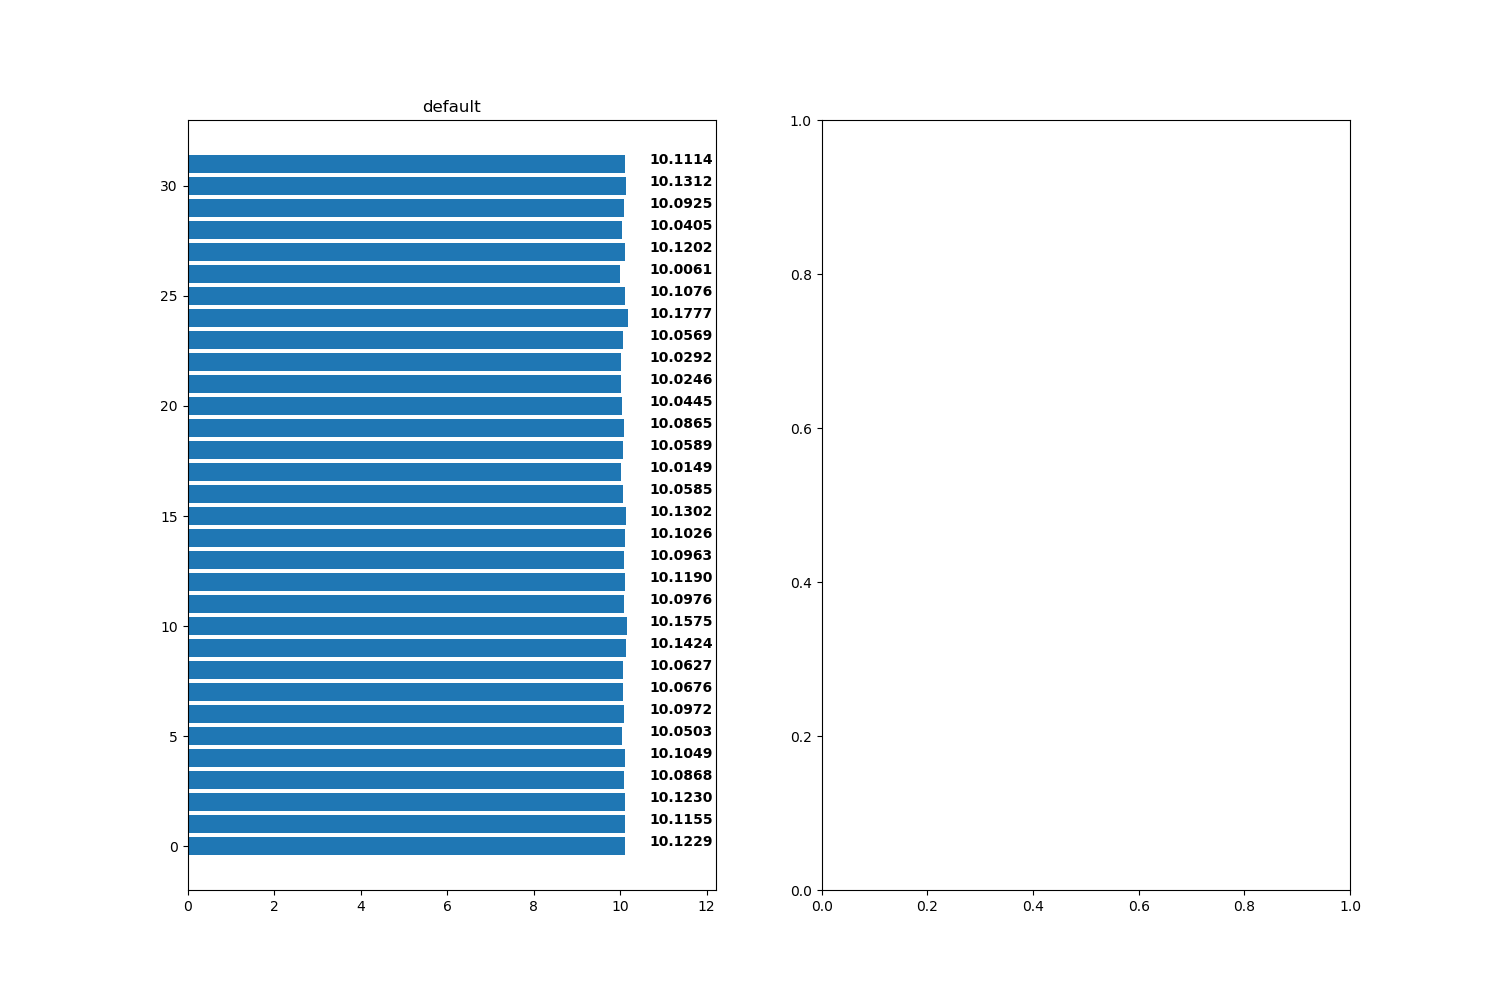

In [5]:
analyzer.plot_average_model_performances('distance')

In [7]:
analyzer.print_params_ranking()

default:

	('model_args', 'hidden_dims'):
				Average result	Variance	Param value
		coord_diff 	4.959234	1.29e-04	[1024, 1024, 1024]
		distance   	10.072581	5.18e-04	[1024, 1024, 1024]
		bone_length	3.632700	8.32e-05	[1024, 1024, 1024]
		proportion 	0.150525	1.13e-06	[1024, 1024, 1024]

	('optimizer_args', 'lr'):
				Average result	Variance	Param value
		coord_diff 	4.959206	1.30e-04	0.0001
		distance   	10.071385	5.98e-04	0.0001
		bone_length	3.624563	4.26e-04	0.0005
		proportion 	0.151257	7.62e-10	0.0001

	('optimizer_args', 'weight_decay'):
				Average result	Variance	Param value
		coord_diff 	4.963229	3.25e-05	1e-05
		distance   	10.081186	1.12e-04	1e-05
		bone_length	3.613068	1.36e-03	1e-05
		proportion 	0.150094	2.79e-06	1e-05

	('model_args', 'dropout'):
				Average result	Variance	Param value
		coord_diff 	4.965913	3.63e-06	None
		distance   	10.085921	1.52e-05	None
		bone_length	3.620873	6.68e-04	0.2
		proportion 	0.151011	1.40e-07	0.2

	('model_args', 'batchnorm'):
				Averag

['[1400, 1400]', '[1024, 1024, 1024]']


<IPython.core.display.Javascript object>


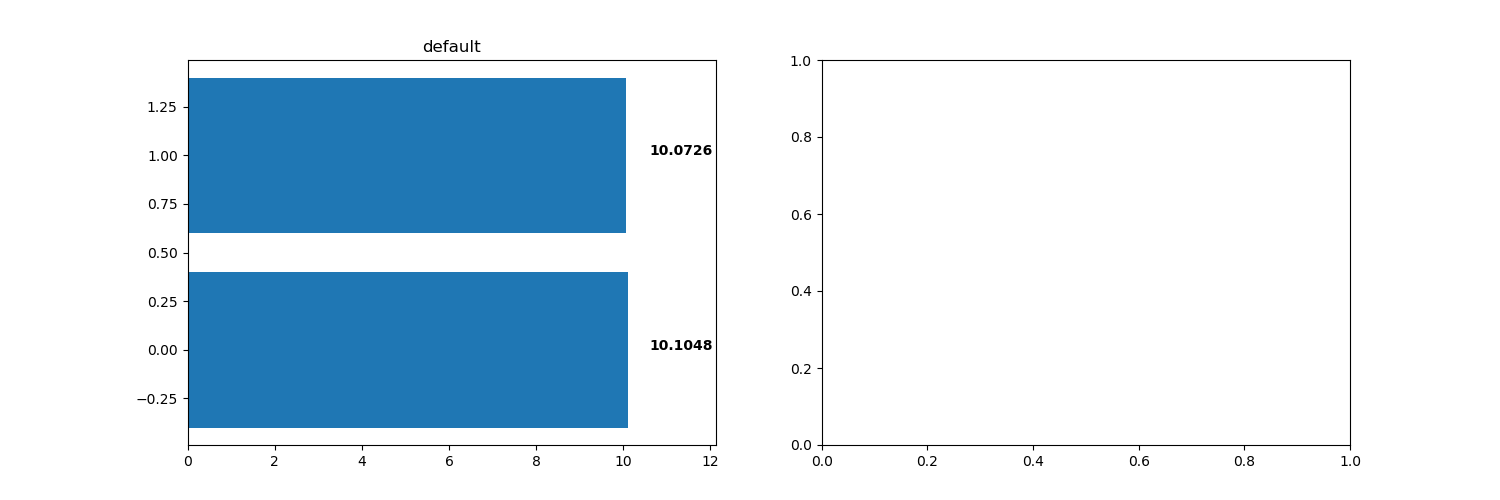

In [6]:
param_name = ('model_args', 'hidden_dims')
#print(analyzer.param_value_index_mapping[param_name])
print([str(val) for val in analyzer.param_value_index_mapping[param_name][0]])
analyzer.plot_average_parameter_performances(param_name, 'distance')

In [ ]:
# Select one
idx = (0, 0)

dataset = datasets.PairedPoseDataset('HANDS17_DPREN_ShapeSplitPruned_val', distorters.NoDistorter(), use_preset=True, device='cuda:0')

model_dir = os.path.join(analyzer.experiment_dir, str(idx[0]), str(idx[1]))
model_analyzer = ModelAnalyzer(model_dir, analyzer.hyperparams[idx[0]], dataset, analyzer.config)
model_analyzer.print_hyperparameters()
print(model_analyzer.hyperparams['loss_function'])

In [ ]:
print(model_analyzer.log['best_epoch'])
model_analyzer.plot_logs()

In [ ]:
model_analyzer.evaluate_dataset('HANDS17ssp_DPREN_val_noshift')
#model_analyzer.evaluate_dataset(mode='max')
#model_analyzer.evaluate_model(mode='max')
model_analyzer.evaluate_model()

In [ ]:
model_analyzer.save_dataset_errors('HANDS17ssp_DPREN_val_noshift_max')

In [ ]:
model_analyzer.compare_success_rate_to(model_analyzer.dataset_errors, 'default', 'DEFAULT', 'distance')

In [ ]:
# Compare evaluation results
model_analyzer.compare_results()

# Wild collection of old evaluation code

In [ ]:
model_errors = []
for k in range(5, 10):
    print(k)
    model_analyzer.model.n_iter = k
    model_analyzer.evaluate_model()
    model_analyzer.compare_results()
    model_errors.append(model_analyzer.errors)

In [ ]:
average_distance_errors = []
average_bone_length_errors = []
average_proportion_errors = []

for k_errors in model_errors:
    k_average_errors = Evaluator.means_per_metric(k_errors['default'])
    average_distance_errors.append(k_average_errors['DEFAULT']['distance'])
    average_bone_length_errors.append(k_average_errors['DEFAULT']['bone_length'])
    average_proportion_errors.append(k_average_errors['DEFAULT']['proportion'])
    
average_distance_errors = torch.stack(average_distance_errors).cpu().numpy()
average_bone_length_errors = torch.stack(average_bone_length_errors).cpu().numpy()
average_proportion_errors = torch.stack(average_proportion_errors).cpu().numpy()

average_distance_errors = average_distance_errors / np.max(average_distance_errors)
average_bone_length_errors = average_bone_length_errors / np.max(average_bone_length_errors)
average_proportion_errors = average_proportion_errors / np.max(average_proportion_errors)

plt.plot(average_distance_errors, label='Distance')
plt.plot(average_bone_length_errors, label='Bone length')
plt.plot(average_proportion_errors, label='Proportion')
plt.xlabel('Message passing iterations')
plt.ylabel('Standardized average error')
plt.legend()
plt.show()

In [ ]:
# Select different model
experiment_name_2 = 'hands17ssp_mlp_knndist_nopre_3'
analyzer_2 = ExperimentAnalyzer(experiment_name_2)
idx_2 = (0, 1)
#dataset_2 = datasets.NormalizedPairedPoseDataset('HANDS17_DPREN_ShapeSplit_val', distorters.NoDistorter(), norm.Shifter, True, device='cuda:0')
dataset_2 = dataset
model_dir_2 = os.path.join(analyzer_2.experiment_dir, str(idx_2[0]), str(idx_2[1]))
model_analyzer_2 = ModelAnalyzer(model_dir_2, analyzer_2.hyperparams[idx_2[0]], dataset_2, analyzer_2.config)

In [ ]:
results_2 = analyzer_2.results[idx_2[0]][idx_2[1]]
#results_2['default'] = results_2['original']
#results_2['original'] = results_2['default']
model_analyzer_2.evaluate_model()
model_analyzer_2.evaluate_dataset('HANDS17ssp_DPREN_val_noshift')
#model_analyzer_2.compare_results()

#model_analyzer.compare_success_rate_to(model_analyzer_2.errors, 'default', 'DEFAULT', 'distance')
#model_analyzer_2.compare_success_rate_to(model_analyzer_2.dataset_errors, 'default', 'DEFAULT', 'distance')

In [ ]:
Evaluator.print_comparison({'default': Evaluator.means_per_metric(model_analyzer.errors['default'])}, {'default': Evaluator.means_per_metric(model_analyzer_2.errors['default'])})

In [ ]:
model_analyzer_2.plot_logs()

In [ ]:
poses = dataset[:].poses

pose_center_shift_error_before = torch.norm(labels.mean(dim=1).cpu() - poses.mean(dim=1).cpu(), dim=1)
pose_center_shift_errors_1 = torch.norm(labels.mean(dim=1).cpu() - model_analyzer.predictions.mean(dim=1), dim=1)
pose_center_shift_errors_2 = torch.norm(labels.mean(dim=1).cpu() - model_analyzer_2.predictions.mean(dim=1), dim=1)
print('Mean pose center shift errors: before: {},\t 1: {},\t2: {}'.format(pose_center_shift_error_before.mean(), pose_center_shift_errors_1.mean(), pose_center_shift_errors_2.mean()))
print(pose_center_shift_errors_1.mean() - pose_center_shift_errors_2.mean())

wrong_shifts_1 = pose_center_shift_errors_1[pose_center_shift_errors_1 > pose_center_shift_error_before]
wrong_shifts_2 = pose_center_shift_errors_2[pose_center_shift_errors_2 > pose_center_shift_error_before]

print('Wrong shifts 1:', len(wrong_shifts_1), wrong_shifts_1.mean(), wrong_shifts_1.max())
print('Wrong shifts 2:', len(wrong_shifts_2), wrong_shifts_2.mean(), wrong_shifts_2.max())

good_shifts_1 = pose_center_shift_errors_1[pose_center_shift_errors_1 < pose_center_shift_error_before]
good_shifts_2 = pose_center_shift_errors_2[pose_center_shift_errors_2 < pose_center_shift_error_before]

print('Good shifts 1:', len(good_shifts_1), good_shifts_1.mean(), good_shifts_1.min())
print('Good shifts 2:', len(good_shifts_2), good_shifts_2.mean(), good_shifts_2.min())



In [ ]:
distance_errors_1 = model_analyzer.errors['default']['DEFAULT']['distance']
distance_errors_2 = model_analyzer_2.errors['default']['DEFAULT']['distance']
improvements =  distance_errors_1 - distance_errors_2
best_improvement_idx = torch.argmin(improvements)

pred_1 = model_analyzer.predictions[best_improvement_idx]
pred_2 = model_analyzer_2.predictions[best_improvement_idx]
label = labels[best_improvement_idx].cpu()
input_pose = dataset[best_improvement_idx].poses.squeeze().cpu()

PoseVisualizer.n_tuple(torch.stack([input_pose, pred_1, pred_2, label]), labels=['Input', 'No shift', 'Shift', 'Label'])

In [ ]:
improv_mask = improvements < 0.0
worse_mask = improvements > 0.0

print(improv_mask.sum())
print(worse_mask.sum())
print(improvements[improv_mask].mean(), improvements[improv_mask].min())
print(improvements[worse_mask].mean(), improvements[worse_mask].max())

In [ ]:
batch = dataset[:10]
#model_output = model_analyzer.model(batch.poses)
#print(model_output[1])
print(model_analyzer.model.normalizer(batch.poses.reshape(-1, 63)))

In [ ]:
result_diff = model_analyzer.errors['original']['DEFAULT']['distance'] - model_analyzer_2.errors['original']['DEFAULT']['distance']
print(torch.min(result_diff))
print(torch.max(result_diff))
plt.hist(result_diff.cpu().numpy(), 100, (-50, 50))
plt.show()

In [ ]:
best_idx = torch.argmin(result_diff)
sample = dataset[best_idx]
#pose_1 = normalization.denormalize_poses(model_analyzer.model(sample.poses), sample.normalization_params)
#pose_2 = normalization.denormalize_poses(model_analyzer_2.model(sample.poses), sample.normalization_params)
pose_1 = model_analyzer.model(sample.poses)
pose_2 = model_analyzer_2.model(sample.poses)


#PoseVisualizer.triplet(torch.stack((sample.original_poses.cpu(), pose_2.detach().cpu(), sample.original_labels.detach().cpu())))
#errors_1 = torch.norm(pose_1 - sample.original_labels, dim=2)
#errors_2 = torch.norm(pose_2 - sample.original_labels, dim=2)
#print(errors_1 - errors_2)
#PoseVisualizer.triplet(torch.stack((pose_1.detach().cpu(), pose_2.detach().cpu(), sample.original_labels.detach().cpu())))
PoseVisualizer.triplet(torch.stack((sample.poses.cpu(), pose_2.detach().cpu(), sample.labels.cpu())))

In [ ]:
# Find extreme cases
val_data = datasets.NormalizedPairedPoseDataset(analyzer.config['experiment']['val_set'], distorters.NoDistorter(), True, device='cuda:0')
model = hyperparams['model'](hyperparams['model_args'])
weights = torch.load(os.path.join(analyzer.experiment_dir, str(idx[0]), str(idx[1]), 'weights.pt'), map_location='cpu')
model.load_state_dict(weights)
model.cuda()

val_data.select_subset('3DCNN')
batch = val_data[:3000]
predictions = model.test(batch.poses).detach()

# Just for large offsets between input and prediction
#eval_batch = datasets.PoseCorrectionBatch(predictions, batch.poses)
#diffs = Evaluator.to_batch(eval_batch)

# For the "best" sample:
errors_before = Evaluator.to_batch(batch)
eval_batch = datasets.PoseCorrectionBatch(predictions, batch.labels)
errors_after = Evaluator.to_batch(eval_batch)
diff = errors_before['distance'] - errors_after['distance']

#most_significant_idx = torch.argmax(diffs['distance'])
most_significant_idx = torch.argmax(diff)
pose = batch.poses[most_significant_idx].reshape(1, 21, 3)
label = batch.labels[most_significant_idx].reshape(1, 21, 3)
prediction = predictions[most_significant_idx].reshape(1, 21, 3)


PoseVisualizer.triplet(pose, prediction, label, [0, 1])
#PoseVisualizer.triplet(denorm_poses['3DCNN'], denorm_pred, denorm_labels)

In [ ]:
# Re-evaluate model
val_data = datasets.NormalizedPairedPoseDataset(analyzer.config['experiment']['val_set'], distorters.NoDistorter(), True, device='cuda:0')
model = hyperparams['model'](hyperparams['model_args'])
weights = torch.load(os.path.join(analyzer.experiment_dir, str(idx[0]), str(idx[1]), 'weights.pt'), map_location='cpu')
model.load_state_dict(weights)
model.cuda()

data_loader = datasets.DataLoader(val_data, 100)
eval_results = Evaluator.to_model(data_loader, model, space='original')
mean_results = Evaluator.means_per_metric(eval_results)
Evaluator.print_results({'original': mean_results})

In [ ]:
idx = 2281
pose = batch.poses[idx].reshape(1, 21, 3)
label = batch.labels[idx].reshape(1, 21, 3)
prediction = predictions[idx].reshape(1, 21, 3)
PoseVisualizer.triplet(pose, prediction, label, [0, 1, 2, 3, 4], True)

pose = batch.original_poses[idx].reshape(1, 21, 3)
label = batch.original_labels[idx].reshape(1, 21, 3)
prediction = normalization.denormalize_poses(predictions, batch.normalization_params)[idx].reshape(1, 21, 3)
PoseVisualizer.triplet(pose, prediction, label, [0, 1, 2, 3, 4], True)

In [ ]:
PoseVisualizer.visualize_evolution(example_data.poses[i].reshape(1, 21, 3), example_predictions[:, 0], example_data.labels[i].reshape(1, 21, 3), [0, 1, 2])

In [ ]:
type(val_data)

In [ ]:
# Compare predictions of GNN and MLP
val_set = datasets.PairedPoseDataset('HANDS17_DPREN_ShapeSplitPruned_val', use_preset=True, device='cuda:0',)

gnn_experiment_dir = 'results/hands17ssp_gnn1_knndist_nopre_1'
gnn_idx = (0, 0)
mlp_experiment_dir = 'results/hands17ssp_mlp_knndist_nopre_3'
mlp_idx = (0, 1)

gnn_training_config = torch.load(os.path.join(gnn_experiment_dir, 'config.pt'))
mlp_training_config = torch.load(os.path.join(mlp_experiment_dir, 'config.pt'))

gnn_session_dir = os.path.join(gnn_experiment_dir, str(gnn_idx[0]))
mlp_session_dir = os.path.join(mlp_experiment_dir, str(mlp_idx[0]))
gnn_hyperparams = torch.load(os.path.join(gnn_session_dir, 'params.pt'))
mlp_hyperparams = torch.load(os.path.join(mlp_session_dir, 'params.pt'))

gnn_model_dir = os.path.join(gnn_session_dir, str(gnn_idx[1]))
mlp_model_dir = os.path.join(mlp_session_dir, str(mlp_idx[1]))

gnn_analyzer = ModelAnalyzer(gnn_model_dir, gnn_hyperparams, val_set, gnn_training_config)
mlp_analyzer = ModelAnalyzer(mlp_model_dir, mlp_hyperparams, val_set, mlp_training_config)

gnn_analyzer.test_model()
mlp_analyzer.test_model()

In [ ]:
labels = val_set[:].labels.cpu()
poses = val_set[:].poses.cpu()
ensemble_predictions = torch.stack([gnn_analyzer.predictions, mlp_analyzer.predictions], dim=1).mean(dim=1)

gnn_distance_errors = torch.norm(labels - gnn_analyzer.predictions, dim=2).mean(dim=1)
mlp_distance_errors = torch.norm(labels - mlp_analyzer.predictions, dim=2).mean(dim=1)
ensemble_distance_errors = torch.norm(labels - ensemble_predictions, dim=2).mean(dim=1)

gnn_center_shift_vecs = labels.mean(dim=1) - gnn_analyzer.predictions.mean(dim=1)
mlp_center_shift_vecs = labels.mean(dim=1) - mlp_analyzer.predictions.mean(dim=1)

gnn_center_shifts = torch.norm(gnn_center_shift_vecs, dim=1)
mlp_center_shifts = torch.norm(mlp_center_shift_vecs, dim=1)

initial_distance_errors = torch.norm(labels - poses, dim=2).mean(dim=1)
gnn_total_improv = gnn_distance_errors - initial_distance_errors
mlp_total_improv = mlp_distance_errors - initial_distance_errors

print('Initial distance error: {:.2f}'.format(initial_distance_errors.mean()))
print('GNN successfully improved the input in {:.1%} of cases'.format((gnn_total_improv < 0).sum().type(torch.float32) / len(val_set)))
print('MLP successfully improved the input in {:.1%} of cases'.format((mlp_total_improv < 0).sum().type(torch.float32) / len(val_set)))

print('Average distance error GNN: {:.2f}'.format(gnn_distance_errors.mean()))
print('Average distance error MLP: {:.2f}'.format(mlp_distance_errors.mean()))
print('Pose center shift distances GNN: {:.2f}'.format(gnn_center_shifts.mean()))
print('Pose center shift distances MLP: {:.2f}'.format(mlp_center_shifts.mean()))

gnn_pred_shift_component = gnn_analyzer.predictions.mean(dim=1) - poses.mean(dim=1)
mlp_pred_shift_component = mlp_analyzer.predictions.mean(dim=1) - poses.mean(dim=1)
ensemble_pred_shift_component = ensemble_predictions.mean(dim=1) - poses.mean(dim=1)

gnn_shiftonly_preds = poses + gnn_pred_shift_component.view(-1, 1, 3)
mlp_shiftonly_preds = poses + mlp_pred_shift_component.view(-1, 1, 3)
ensemble_shiftonly_preds = poses + ensemble_pred_shift_component.view(-1, 1, 3)

gnn_shiftonly_distance_errors = torch.norm(labels - gnn_shiftonly_preds, dim=2).mean(dim=1)
mlp_shiftonly_distance_errors = torch.norm(labels - mlp_shiftonly_preds, dim=2).mean(dim=1)
ensemble_shiftonly_distance_errors = torch.norm(labels - ensemble_shiftonly_preds, dim=2).mean(dim=1)

print('Average distance error for GNN when only applying the shifts: {:.2f}'.format(gnn_shiftonly_distance_errors.mean()))
print('Average distance error for MLP when only applying the shifts: {:.2f}'.format(mlp_shiftonly_distance_errors.mean()))

ensemble_errors = Evaluator.means_per_metric({'default': Evaluator.to_batch(datasets.PoseCorrectionBatch(ensemble_predictions, labels))})
print('Average distance error ensemble: {:.3f}'.format(ensemble_errors['default']['distance']))
print('Average bone length error ensemble: {:.3f}'.format(ensemble_errors['default']['bone_length']))
print('Average proportion error ensemble: {:.3f}'.format(ensemble_errors['default']['proportion']))

In [ ]:
print('Variance GNN: {:.2f}'.format(torch.var(gnn_distance_errors)))
print('Variance MLP: {:.2f}'.format(torch.var(mlp_distance_errors)))

gnn_improv = gnn_distance_errors - mlp_distance_errors
gnn_center_improv = gnn_center_shifts - mlp_center_shifts

print('GNN is better in {:.1%} of cases'.format((gnn_improv < 0).sum().type(torch.float32) / len(val_set)))
print('Max improvement: {:.2f}'.format(gnn_improv.min()))
print('Max worsening: {:.2f}'.format(gnn_improv.max()))
print('Max center shift improvement: {:.2f}'.format(gnn_center_improv.min()))
print('Max center shift worsening: {:.2f}'.format(gnn_center_improv.max()))

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

abs_diff = gnn_improv.abs()
abs_center_diff = gnn_center_improv.abs()

thresholds = np.linspace(0.0, abs_diff.max().cpu().numpy(), 100)

n_lower = [(abs_diff < threshold).sum().type(torch.float32).cpu().numpy() / len(val_set) * 100 for threshold in thresholds]
n_center_lower = [(abs_center_diff < threshold).sum().type(torch.float32).cpu().numpy() / len(val_set) * 100 for threshold in thresholds]

axes[0].plot(thresholds, n_lower, label='Distance error')
axes[0].plot(thresholds, n_center_lower, label='Center shift')
axes[0].set_xlabel('Absolute difference between MLP and GNN')
axes[0].set_ylabel('Percentage of samples with lower differences')
axes[0].legend()

improv_mask = gnn_improv < 0.0
n_lower_better = [(gnn_improv[improv_mask] > -threshold).sum().type(torch.float32).cpu().numpy() / improv_mask.sum().item() * 100 for threshold in thresholds]
n_lower_worse = [(gnn_improv[~improv_mask] < threshold).sum().type(torch.float32).cpu().numpy() / (~improv_mask).sum().item() * 100 for threshold in thresholds]

axes[1].plot(thresholds, n_lower_better, label='GNN better than MLP')
axes[1].plot(thresholds, n_lower_worse, label='GNN worse than MLP')
axes[1].set_xlabel('Absolute difference between MLP and GNN')
axes[1].set_ylabel('Percentage of samples with lower differences')
axes[1].legend()

plt.show()

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15), squeeze=False, sharey=True)

gnn_after_shift_improv = gnn_distance_errors - gnn_shiftonly_distance_errors
mlp_after_shift_improv = mlp_distance_errors - mlp_shiftonly_distance_errors
ensemble_after_shift_improv = ensemble_distance_errors - ensemble_shiftonly_distance_errors

gnn_pred_shift_distances = gnn_pred_shift_component.norm(dim=1).cpu().numpy()
mlp_pred_shift_distances = mlp_pred_shift_component.norm(dim=1).cpu().numpy()
ensemble_pred_shift_distances = ensemble_pred_shift_component.norm(dim=1).numpy()

axes[0, 0].scatter(gnn_pred_shift_distances, gnn_after_shift_improv.cpu().numpy(), s=1, alpha=0.1)
axes[0, 0].set_ylabel('Improvement after shift')
axes[0, 0].set_title('GNN')
axes[0, 1].scatter(mlp_pred_shift_distances, mlp_after_shift_improv.cpu().numpy(), s=1, alpha=0.1)
axes[0, 1].set_title('MLP')
axes[0, 0].axhline(y=0, color='grey', alpha=0.5)
axes[0, 1].axhline(y=0, color='grey', alpha=0.5)
fig.text(0.5, 0.00, 'Predicted shift distance', ha='center')

def slice_variance(x, y, lower_threshold, upper_threshold):
    below_upper_mask = x < upper_threshold
    above_lower_mask = x > lower_threshold
    between_mask = below_upper_mask * above_lower_mask
    subset = y[between_mask]
    return np.nan_to_num(subset.var(), 0.0)

thresholds = np.linspace(0.0, max(gnn_pred_shift_distances.max(), mlp_pred_shift_distances.max()), 40)
gnn_improv_variances = [slice_variance(gnn_pred_shift_distances, gnn_after_shift_improv.cpu().numpy(), t1, t2) for t1, t2 in zip(thresholds[:-1], thresholds[1:])]
mlp_improv_variances = [slice_variance(mlp_pred_shift_distances, mlp_after_shift_improv.cpu().numpy(), t1, t2) for t1, t2 in zip(thresholds[:-1], thresholds[1:])]

ax0_twin = axes[0, 0].twinx()
ax0_twin.plot(thresholds[:-1], gnn_improv_variances, color='orange')
ax0_twin.set_ylim((0.0, 4.0))

ax1_twin = axes[0, 1].twinx()
ax1_twin.plot(thresholds[:-1], mlp_improv_variances, color='orange')
ax1_twin.set_ylabel('Variance')
ax1_twin.set_ylim((0.0, 4.0))

ensemble_uncertainties = torch.norm(gnn_analyzer.predictions - mlp_analyzer.predictions, dim=2).mean(dim=1)
topk_uncertainties, topk_uncertain_indices = torch.topk(ensemble_uncertainties, k=100, largest=True)
print(topk_uncertainties.min())

axes[1, 0].scatter(ensemble_pred_shift_distances, ensemble_after_shift_improv.numpy(), s=1, alpha=0.1)
axes[1, 0].scatter(ensemble_pred_shift_distances[topk_uncertain_indices], ensemble_after_shift_improv[topk_uncertain_indices].numpy(), s=2, alpha=0.5, color='red')
axes[1, 0].axhline(y=0, color='grey', alpha=0.5)
axes[1, 1].scatter(gnn_pred_shift_distances, gnn_total_improv.cpu().numpy(), s=1, alpha=0.1)
axes[1, 1].scatter(gnn_pred_shift_distances[topk_uncertain_indices], gnn_total_improv[topk_uncertain_indices].cpu().numpy(), s=2, alpha=0.5, color='red')
axes[1, 1].axhline(y=0, color='grey', alpha=0.5)

plt.show()

In [ ]:
# TODO: Select subset where the predicted shift is low --> visualize the best and worst corrections from GNN vs MLP

pred_shift_distance_threshold = 1.0
mask = torch.from_numpy(gnn_pred_shift_distances < pred_shift_distance_threshold)
print(len(torch.nonzero(mask)))

print('Subset mean distance error GNN:', gnn_distance_errors[mask].mean())
print('Subset mean distance error MLP:', mlp_distance_errors[mask].mean())

k = 6
topk_improvements = torch.topk(gnn_improv[mask], k=k, largest=False)
topk_worsenings = torch.topk(gnn_improv[mask], k=k, largest=True)

print('Top k improvements')
print('Improvement\tGNN Error\tMLP Error\tCenter Shift Improvement')
for idx in topk_improvements.indices:
    print('{:.2f}\t\t{:.2f}\t\t{:.2f}\t\t{:.2f}'.format(gnn_improv[mask][idx], gnn_distance_errors[mask][idx], mlp_distance_errors[mask][idx], gnn_center_improv[mask][idx]))

print('\nTop k worsenings')
print('Improvement\tGNN Error\tMLP Error\tCenter Shift Improvement')
for idx in topk_worsenings.indices:
    print('{:.2f}\t\t{:.2f}\t\t{:.2f}\t\t{:.2f}'.format(gnn_improv[mask][idx], gnn_distance_errors[mask][idx], mlp_distance_errors[mask][idx], gnn_center_improv[mask][idx]))
    
batch = val_set[mask]
gnn_triplet_batch = torch.stack([batch.poses[topk_improvements.indices].cpu(),
                                 gnn_analyzer.predictions[mask][topk_improvements.indices], 
                                 batch.labels[topk_improvements.indices].cpu()], dim=1)
mlp_triplet_batch = torch.stack([batch.poses[topk_improvements.indices].cpu(),
                                 mlp_analyzer.predictions[mask][topk_improvements.indices], 
                                 batch.labels[topk_improvements.indices].cpu()], dim=1)

PoseVisualizer.triplet_batch(gnn_triplet_batch)
PoseVisualizer.triplet_batch(mlp_triplet_batch)

In [ ]:
topk_gnn_errors, topk_gnn_error_indices = torch.topk(gnn_total_improv[mask], k=k, largest=False)
gnn_triplet_batch = torch.stack([batch.poses[topk_gnn_error_indices].cpu(),
                                 gnn_analyzer.predictions[mask][topk_gnn_error_indices], 
                                 batch.labels[topk_gnn_error_indices].cpu()], dim=1)
PoseVisualizer.triplet_batch(gnn_triplet_batch, visible_fingers=[0, 2, 4])

In [ ]:
gnn_corrected_poses = gnn_analyzer.predictions[:100]
mlp_corrected_poses = mlp_analyzer.predictions[:100]

print('GNN corrected once: {:.2f}'.format(torch.norm(gnn_corrected_poses - labels[:100], dim=2).mean()))
print('MLP corrected once: {:.2f}'.format(torch.norm(mlp_corrected_poses - labels[:100], dim=2).mean()))

gnn_double_corrected = gnn_analyzer.model.test(gnn_corrected_poses.cuda())
mlp_double_corrected = mlp_analyzer.model.test(mlp_corrected_poses.cuda())

print('GNN corrected once: {:.2f}'.format(torch.norm(gnn_double_corrected.cpu() - labels[:100], dim=2).mean()))
print('MLP corrected once: {:.2f}'.format(torch.norm(mlp_double_corrected.cpu() - labels[:100], dim=2).mean()))

PoseVisualizer.triplet_batch(torch.stack([poses[:9], gnn_corrected_poses[:9], gnn_double_corrected[:9].cpu().detach()], dim=1))

In [ ]:
torch.save(mlp_analyzer.predictions, 'data/HANDS17_CorrctMLP_SSP_train_poses.pt')